In [10]:
%cd /kaggle/input/chemcancer-v2/src/
%mkdir /kaggle/working/Deep_Learning_metrics/
%mkdir /kaggle/working/During_train/
%mkdir /kaggle/working/CV_VIT_models
%mkdir /kaggle/working/CV_VIT_results
%mkdir /kaggle/working/CV_fold_data

/kaggle/input/chemcancer-v2/src
mkdir: cannot create directory '/kaggle/working/Deep_Learning_metrics/': File exists
mkdir: cannot create directory '/kaggle/working/During_train/': File exists
mkdir: cannot create directory '/kaggle/working/CV_VIT_models': File exists
mkdir: cannot create directory '/kaggle/working/CV_VIT_results': File exists
mkdir: cannot create directory '/kaggle/working/CV_fold_data': File exists


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.optimizers import Adam
from data import *
from machine_learning_models import *
from deep_learning_models import *
from vision_transformer import *
from utils_dl_model import *
from utils_ml_model import print_ml_results
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [12]:
# Set the seed value.
SEED = 7
np.random.seed(SEED)

# Deep Learning parameters
DL_EPOCH = 30
DL_BATCH_SIZE = 32
DL_CNN_VERSION = 3
DL_TRANSFORMER_VISION_VERSION = 14
DL_CV_FOLD = 5

DO_DL = True
CV_DL = True
OPT_DL = False

DO_CNN = False
DO_TRANSFORMER_VISION = True
DO_ML = False

# Percentage of test set out of the dataset.
TEST_SET = 0.2

# Percentage of validation set out of the training dataset.
VAL_SET = 0.2

# Folder path associated with deep learning models
dl_models_folder = "../Deep_Learning_models/"
dl_metrics_folder = "../Deep_Learning_metrics/"
dl_weights_folder = "../Deep_Learning_weights/"
dl_cv_models_folder = "../Deep_Learning_CV/"
dl_cv_results_folder = "../Deep_Learning_CV_results/"

# Folder path associated with machine learning models
ml_models_folder = "../Machine_Learning_models/"
ml_models_results_folder = "../Machine_Learning_models_results/"

# Model names (Saved in h5 format)
cnn_model_name = f"cnn_v{DL_CNN_VERSION}_{DL_BATCH_SIZE}_{DL_EPOCH}_seed_{SEED}.h5"
transformer_vis_model_name = f"transformer_vision_v{DL_TRANSFORMER_VISION_VERSION}_{DL_BATCH_SIZE}_{DL_EPOCH}_seed_{SEED}.h5"

# Metric filenames
cnn_metrics_filename = f"metrics_{cnn_model_name}.json"
transformer_vis_metrics_filename = f"metrics_{transformer_vis_model_name}.json"

# Weight filenames
cnn_weights_filename = f"weights_{cnn_model_name}.json"
transformer_vis_weights_filename = f"weights_{transformer_vis_model_name}.json"


# Deep Learning models path
if DO_CNN:
    dl_model_path = os.path.join(
        dl_models_folder, cnn_model_name)
elif DO_TRANSFORMER_VISION:
    dl_model_path = os.path.join(
        dl_models_folder, transformer_vis_model_name)


# Deep Learning metrics path
if DO_CNN:
    dl_metrics_path = os.path.join(
        dl_metrics_folder, cnn_metrics_filename)
elif DO_TRANSFORMER_VISION:
    dl_metrics_path = os.path.join(
        dl_metrics_folder, transformer_vis_metrics_filename)


# Deep Learning weights path
if DO_CNN:
    dl_weights_path = os.path.join(
        dl_weights_folder, cnn_weights_filename)

elif DO_TRANSFORMER_VISION:
    dl_weights_path = os.path.join(
        dl_weights_folder, transformer_vis_weights_filename)

In [13]:
import pickle

def perform_vit_cross_validation(X_original, y_original, X_augmented, y_augmented, patch_size, embed_dim, num_heads, mlp_dim, num_layers, dropout_rate,
                                 n_splits=5, epochs=100, batch_size=32, vit_version = 1, val_set = 0.2,
                                 do_opt = False,models_folder = "models", results_folder = "results"):
    
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    # Initialize variables for tracking the best model
    best_val_accuracy = 0
    best_model_filepath = ""
    
    accuracies = []
    test_losses = []
    test_accuracies = []
    
    # Initialize lists to store precision, recall, and F1 scores
    precisions = []
    recalls = []
    f1_scores = []
    
    # Initialize lists to store losses and accuracies for each epoch
    mean_training_losses = []
    mean_training_accuracies = []
    mean_val_losses = []   
    mean_val_accuracies = []
    
    fold = 1
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)
    skf_augmented = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)
    
    for train_index, _ in skf_augmented.split(X_augmented, y_augmented):
        # We are only interested in the train index for augmented data
        # Select the augmented data for training
        print("=" * 40)
        print(f"Fold: {fold}")
        print("Selecting the augmented data")
        
        X_train = X_augmented[train_index]
        y_train = y_augmented[train_index]
        X_ori = X_original
        
#         print("Apply Filters")
#         X_train =  apply_filters_and_background_subtraction(X_train)
#         X_ori =  apply_filters_and_background_subtraction(X_ori)
            
        # Standardize the data
        print("Standardizing the data")
        X_train, X_ori = standardize_data(X_train, X_ori)
        
        # Reshape the data
        print("Reshaping the data for deep learning models")
        X_train, X_ori = reshape_data(X_train, X_ori)
        
        # Input shape and number of classes for the model
        input_shape = (X_train.shape[1], 1)
        num_classes = len(np.unique(y_original))
        
        # Split a portion of the original data for validation and testing (stratified based on y_original)
        X_val, X_test, y_val, y_test = train_test_split(X_ori, y_original, test_size = 0.7, random_state = seed_value, stratify = y_original)
        
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"X_val shape: {X_val.shape}")
        
        num_patches = input_shape[0] // patch_size
        try:
            if do_opt:
                # Create the model
                model = create_vit(input_shape, patch_size, num_patches, num_classes,
                                embed_dim, num_heads, mlp_dim, num_layers, dropout_rate)
                model.summary()
                # Compile the model
                model.compile(
#                     optimizer=Adam(learning_rate=0.0001), loss=weighted_sparse_categorical_crossentropy(class_weights), metrics=['accuracy'])
                    optimizer=Adam(learning_rate = 1e-4),loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            else:
                # Create the model
                print("Building the vit model with the following hyperparameters:")
                print(f"Patch size: {learning_rate}")
                print(f"num_patches: {num_patches}") 
                print(f"embed_dim: {embed_dim}")
                print(f"num_heads: {num_heads}")
                print(f"mlp_dim: {mlp_dim}")
                print(f"num_layers: {num_layers}")
                print(f"dropout_rate: {dropout_rate}")
                model = create_vit(input_shape, patch_size, num_patches, num_classes,
                                embed_dim, num_heads, mlp_dim, num_layers, dropout_rate)
                model.summary()
                # Compile the model
                model.compile(
#                     optimizer=Adam(learning_rate=0.0001), loss=weighted_sparse_categorical_crossentropy(class_weights), metrics=['accuracy'])
                    optimizer=Adam(learning_rate = 1e-4),loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            if model is not None:
                "Build VIT"
                # model.summary()
            else:
                print("Failed to build the VIT model.")
        except Exception as e:
            print(f"Error while building the VIT model: {e}")
        
        print("Saving the data")
        fold_data = {

            'X_train': X_train,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test
        }

        with open(f"/kaggle/working/CV_fold_data/fold_{fold}_data.pkl", 'wb') as f:
            pickle.dump(fold_data, f)
            
        filepath = f'/kaggle/working/CV_VIT_models/temp_best_fold_{fold}.h5'
        # the ModelCheckpoint callback to save the best model of the current fold
        model_checkpoint_callback = ModelCheckpoint(
            filepath=os.path.join(filepath),
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
        
        print("Training the model")
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                           callbacks=[model_checkpoint_callback])
         
        # Check if this model is the best so far
        max_val_accuracy_this_fold = max(history.history['val_accuracy'])
        if max_val_accuracy_this_fold > best_val_accuracy:
            best_val_accuracy = max_val_accuracy_this_fold
            best_model_filepath = filepath
            
        if best_model_filepath:
            best_model = tf.keras.models.load_model(
                best_model_filepath,
                custom_objects={'ClassToken': ClassToken, 'TransformerBlock': TransformerBlock})
#                     'loss': weighted_sparse_categorical_crossentropy(class_weights)}}
            print(f"The best model was loaded and ready to be evaluated")
        
        
        
        y_pred = np.argmax(model.predict(X_test), axis=-1)
        accuracy = accuracy_score(y_test, y_pred)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
            # Calculate precision, recall, and F1 score
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Append the scores to the lists
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        # Append the losses and accuracies for each epoch to the respective lists
        for epoch in range(epochs):
            if fold == 1:
                # For the first fold, initialize the lists with the first fold's values
                mean_training_losses.append(history.history['loss'][epoch])
                mean_training_accuracies.append(history.history['accuracy'][epoch])
                mean_val_losses.append(history.history['val_loss'][epoch])
                mean_val_accuracies.append(history.history['val_accuracy'][epoch])
            else:
                # For subsequent folds, add the fold's values to the running sum
                mean_training_losses[epoch] += history.history['loss'][epoch]
                mean_training_accuracies[epoch] += history.history['accuracy'][epoch]
                mean_val_losses[epoch] += history.history['val_loss'][epoch]
                mean_val_accuracies[epoch] += history.history['val_accuracy'][epoch]

        # Save the model
        if do_opt:
            model_filename = f"VIT_v{vit_version}_opt_{batch_size}_{epochs}_seed{seed_value}.h5"
        else:
            model_filename = f"VIT_v{vit_version}_{batch_size}_{epochs}_seed{seed_value}.h5"
        model_filepath = os.path.join(models_folder, f"fold_{fold}_split_{n_splits}_{model_filename}")
        model.save(model_filepath)

        # Save the results as a JSON file
        if do_opt:
            results_filename = f"VIT_v{vit_version}_opt_{batch_size}_{epochs}_seed{seed_value}.json"
        else:
            results_filename = f"VIT_v{vit_version}_{batch_size}_{epochs}_seed{seed_value}.json"
        results_filepath = os.path.join(results_folder, f"fold_{fold}_split_{n_splits}_{results_filename}")

        results = {
            "fold": fold,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_scores": f1_scores,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_loss": history.history['loss'],
            "training_accuracy": history.history['accuracy'],
            "validation_loss": history.history['val_loss'],
            "validation_accuracy": history.history['val_accuracy'],
        }

        with open(results_filepath, "w") as results_file:
            json.dump(results, results_file, indent=4)
        
        # Append the results to the lists
        accuracies.append(accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Fold {fold}, Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print("=" * 40)
        fold += 1

    # At the end, divide the sums by the number of folds to get the mean
    mean_training_losses = [loss / n_splits for loss in mean_training_losses]
    mean_training_accuracies = [acc / n_splits for acc in mean_training_accuracies]
    mean_val_losses = [loss / n_splits for loss in mean_val_losses]
    mean_val_accuracies = [acc / n_splits for acc in mean_val_accuracies]
    # Convert lists to numpy arrays for easier calculation of mean and standard deviation
    mean_accuracy = np.mean(accuracies)
    mean_test_loss = np.mean(test_losses)
    mean_test_accuracy = np.mean(test_accuracies)

    # Calculate standard deviations
    std_accuracy = np.std(accuracies)
    std_test_loss = np.std(test_losses)
    std_test_accuracy = np.std(test_accuracies)

    std_training_loss = np.std(mean_training_losses)
    std_training_accuracy = np.std(mean_training_accuracies)
    std_val_loss = np.std(mean_val_losses)
    std_val_accuracy = np.std(mean_val_accuracies)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)

      
    print(f"test losses: {test_losses}")
    print(f"test accuracy: {test_accuracies}")
    
    print("*" * 40)
    print(f"Mean training loss over stratified {n_splits}-fold cross-validation: {np.mean(mean_training_losses):.4f}")
    print(f"Mean training accuracy over stratified {n_splits}-fold cross-validation: {np.mean(mean_training_accuracies):.4f}")
    print(f"Mean validation loss over stratified {n_splits}-fold cross-validation: {np.mean(mean_val_losses):.4f}")
    print(f"Mean validation accuracy over stratified {n_splits}-fold cross-validation: {np.mean(mean_val_accuracies):.4f}")
    print("*" * 40)
    print(f"Mean accuracy over stratified {n_splits}-fold cross-validation: {mean_accuracy:.4f}")
    print(f"Mean test loss over stratified {n_splits}-fold cross-validation: {mean_test_loss:.4f}")
    print(f"Mean test accuracy over stratified {n_splits}-fold cross-validation: {mean_test_accuracy:.4f}")
    print("*" * 40)

    print(f"Standard deviation of training loss over stratified {n_splits}-fold cross-validation: {np.std(mean_training_losses):.4f}")
    print(f"Standard deviation of training accuracy over stratified {n_splits}-fold cross-validation: {np.std(mean_training_accuracies):.4f}")
    print(f"Standard deviation of validation loss over stratified {n_splits}-fold cross-validation: {np.std(mean_val_losses):.4f}")
    print(f"Standard deviation of validation accuracy over stratified {n_splits}-fold cross-validation: {np.std(mean_val_accuracies):.4f}")
    print("*" * 40)
    print(f"Standard deviation of accuracy over stratified {n_splits}-fold cross-validation: {std_accuracy:.4f}")
    print(f"Standard deviation of test loss over stratified {n_splits}-fold cross-validation: {std_test_loss:.4f}")
    print(f"Standard deviation of test accuracy over stratified {n_splits}-fold cross-validation: {std_test_accuracy:.4f}")
    print("*" * 40)
    
    # Calculate and print the mean and standard deviation of precision, recall, and F1 score
    print(f"Mean precision over stratified {n_splits}-fold cross-validation: {np.mean(precisions):.4f}")
    print(f"Standard deviation of precision over stratified {n_splits}-fold cross-validation: {np.std(precisions):.4f}")
    print(f"Mean recall over stratified {n_splits}-fold cross-validation: {np.mean(recalls):.4f}")
    print(f"Standard deviation of recall over stratified {n_splits}-fold cross-validation: {np.std(recalls):.4f}")
    print(f"Mean F1 score over stratified {n_splits}-fold cross-validation: {np.mean(f1_scores):.4f}")
    print(f"Standard deviation of F1 score over stratified {n_splits}-fold cross-validation: {np.std(f1_scores):.4f}")

    
# Define the directory where the JSON files are stored

    fig, axes = plt.subplots(2, n_splits, figsize=(20, 10))

    for fold in range(1, n_splits+1):
        # Load the JSON file for this fold
        if do_opt:
            cnn_filename = f"VIT_v{vit_version}_opt_{batch_size}_{epochs}_seed{seed_value}.json"
        else:
            cnn_filename = f"VIT_v{vit_version}_{batch_size}_{epochs}_seed{seed_value}.json"
        results_filename = f"fold_{fold}_split_{n_splits}_{cnn_filename}"
        
        results_filepath = os.path.join(results_folder, results_filename)
        
        with open(results_filepath, "r") as results_file:
            results = json.load(results_file)
        
        # Plot training and validation loss
        axes[0, fold-1].plot(results["training_loss"], label='Train')
        axes[0, fold-1].plot(results["validation_loss"], label='Validation')
        axes[0, fold-1].set_title(f'Fold {fold} Loss')
        axes[0, fold-1].set_xlabel('Epochs')
        axes[0, fold-1].set_ylabel('Loss')
        axes[0, fold-1].legend()

        # Plot training and validation accuracy
        axes[1, fold-1].plot(results["training_accuracy"], label='Train')
        axes[1, fold-1].plot(results["validation_accuracy"], label='Validation')
        axes[1, fold-1].set_title(f'Fold {fold} Accuracy')
        axes[1, fold-1].set_xlabel('Epochs')
        axes[1, fold-1].set_ylabel('Accuracy')
        axes[1, fold-1].legend()

    plt.tight_layout()
    plt.show()
    
    return mean_val_accuracies  

In [14]:
def extract_data_from_csv(filename="generated_data.csv"):
    # Read the CSV file into a DataFrame
    df_extracted = pd.read_csv(filename)
    
    # Split the DataFrame into features and labels
    X_extracted = df_extracted.drop(columns=["labels"]).values
    y_extracted = df_extracted["labels"].values
    
    return X_extracted, y_extracted

In [15]:
# With bksb, slope and roll set to true
test_data= "/kaggle/input/test-gen-cc-10x-v4/test-gen-cc-10x-v4.csv"

# No bksb, slope and roll set to false
train_data = "/kaggle/input/gen-cc-10x-v4/gen-cc-10x-v4.csv"

In [16]:
X_augmented, y_augmented = extract_data_from_csv(train_data)
print(f"X_augmented shaped: {X_augmented.shape}")
print(f"y_augmented shaped: {y_augmented.shape}")

X_original, y_original = extract_data_from_csv(test_data)
print(f"X_original shaped: {X_original.shape}")
print(f"y_original shaped: {y_original.shape}")

X_augmented shaped: (18980, 270)
y_augmented shaped: (18980,)
X_original shaped: (475, 270)
y_original shaped: (475,)


Building Transformer model...
Fold: 1
Selecting the augmented data
Standardizing the data
Reshaping the data for deep learning models
X_train shape: (15184, 270, 1)
X_test shape: (333, 270, 1)
X_val shape: (142, 270, 1)
Input shape: (None, 270, 1)
No. of patches: 9
Num Patches: 9
Patch Embed shape: (None, 9, 64)
Positions shape: (9,)
Positional Embed shape: (9, 64)
Embed shape: (None, 9, 64)
Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_65 (InputLayer)       [(None, 270, 1)]             0         []                            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 9, 64)                1984      ['input_65[0][0]']            
                                                                                            

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


475/475 [==============================] - 8s 18ms/step - loss: 1.3510 - accuracy: 0.3770 - val_loss: 1.0130 - val_accuracy: 0.5211
Epoch 3/30
475/475 [==============================] - 8s 18ms/step - loss: 1.2376 - accuracy: 0.3903 - val_loss: 0.9615 - val_accuracy: 0.5352
Epoch 4/30
475/475 [==============================] - 8s 17ms/step - loss: 1.1373 - accuracy: 0.4299 - val_loss: 0.9520 - val_accuracy: 0.5282
Epoch 5/30
475/475 [==============================] - 8s 17ms/step - loss: 0.9737 - accuracy: 0.5254 - val_loss: 0.8684 - val_accuracy: 0.5915
Epoch 6/30
475/475 [==============================] - 8s 17ms/step - loss: 0.8348 - accuracy: 0.6136 - val_loss: 0.8174 - val_accuracy: 0.6197
Epoch 7/30
475/475 [==============================] - 8s 17ms/step - loss: 0.7158 - accuracy: 0.6830 - val_loss: 0.7323 - val_accuracy: 0.6831
Epoch 8/30
475/475 [==============================] - 8s 17ms/step - loss: 0.6301 - accuracy: 0.7297 - val_loss: 0.7733 - val_accuracy: 0.7042
Epoch 9/30

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Reshaping the data for deep learning models
X_train shape: (15184, 270, 1)
X_test shape: (333, 270, 1)
X_val shape: (142, 270, 1)
Input shape: (None, 270, 1)
No. of patches: 9
Num Patches: 9
Patch Embed shape: (None, 9, 64)
Positions shape: (9,)
Positional Embed shape: (9, 64)
Embed shape: (None, 9, 64)
Model: "model_77"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_74 (InputLayer)       [(None, 270, 1)]             0         []                            
                                                                                                  
 conv1d_13 (Conv1D)          (None, 9, 64)                1984      ['input_74[0][0]']            
                                                                                                  
 tf.__operators__.add_13 (T  (None, 9, 64)                0         ['conv1d_13[0][

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


475/475 [==============================] - 8s 17ms/step - loss: 1.3428 - accuracy: 0.3827 - val_loss: 0.9940 - val_accuracy: 0.4577
Epoch 3/30
475/475 [==============================] - 8s 17ms/step - loss: 1.2140 - accuracy: 0.3999 - val_loss: 0.9280 - val_accuracy: 0.5775
Epoch 4/30
475/475 [==============================] - 8s 17ms/step - loss: 1.0725 - accuracy: 0.4702 - val_loss: 0.9139 - val_accuracy: 0.5141
Epoch 5/30
475/475 [==============================] - 8s 17ms/step - loss: 0.9240 - accuracy: 0.5493 - val_loss: 0.8468 - val_accuracy: 0.5845
Epoch 6/30
475/475 [==============================] - 8s 17ms/step - loss: 0.7884 - accuracy: 0.6430 - val_loss: 0.7876 - val_accuracy: 0.6338
Epoch 7/30
475/475 [==============================] - 8s 17ms/step - loss: 0.6886 - accuracy: 0.7008 - val_loss: 0.8185 - val_accuracy: 0.5986
Epoch 8/30
475/475 [==============================] - 8s 18ms/step - loss: 0.6033 - accuracy: 0.7460 - val_loss: 0.6864 - val_accuracy: 0.7465
Epoch 9/30

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Reshaping the data for deep learning models
X_train shape: (15184, 270, 1)
X_test shape: (333, 270, 1)
X_val shape: (142, 270, 1)
Input shape: (None, 270, 1)
No. of patches: 9
Num Patches: 9
Patch Embed shape: (None, 9, 64)
Positions shape: (9,)
Positional Embed shape: (9, 64)
Embed shape: (None, 9, 64)
Model: "model_86"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_83 (InputLayer)       [(None, 270, 1)]             0         []                            
                                                                                                  
 conv1d_14 (Conv1D)          (None, 9, 64)                1984      ['input_83[0][0]']            
                                                                                                  
 tf.__operators__.add_14 (T  (None, 9, 64)                0         ['conv1d_14[0][

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


475/475 [==============================] - 8s 18ms/step - loss: 1.3462 - accuracy: 0.3796 - val_loss: 0.9889 - val_accuracy: 0.5141
Epoch 3/30
475/475 [==============================] - 8s 17ms/step - loss: 1.2390 - accuracy: 0.3886 - val_loss: 0.9857 - val_accuracy: 0.5282
Epoch 4/30
475/475 [==============================] - 8s 17ms/step - loss: 1.1614 - accuracy: 0.4054 - val_loss: 0.9479 - val_accuracy: 0.5141
Epoch 5/30
475/475 [==============================] - 8s 17ms/step - loss: 1.0688 - accuracy: 0.4629 - val_loss: 0.9082 - val_accuracy: 0.5634
Epoch 6/30
475/475 [==============================] - 8s 17ms/step - loss: 0.8847 - accuracy: 0.5780 - val_loss: 0.8204 - val_accuracy: 0.5915
Epoch 7/30
475/475 [==============================] - 8s 18ms/step - loss: 0.7304 - accuracy: 0.6758 - val_loss: 0.7485 - val_accuracy: 0.6549
Epoch 8/30
475/475 [==============================] - 8s 17ms/step - loss: 0.6629 - accuracy: 0.7156 - val_loss: 0.7143 - val_accuracy: 0.6831
Epoch 9/30

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Reshaping the data for deep learning models
X_train shape: (15184, 270, 1)
X_test shape: (333, 270, 1)
X_val shape: (142, 270, 1)
Input shape: (None, 270, 1)
No. of patches: 9
Num Patches: 9
Patch Embed shape: (None, 9, 64)
Positions shape: (9,)
Positional Embed shape: (9, 64)
Embed shape: (None, 9, 64)
Model: "model_95"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_92 (InputLayer)       [(None, 270, 1)]             0         []                            
                                                                                                  
 conv1d_15 (Conv1D)          (None, 9, 64)                1984      ['input_92[0][0]']            
                                                                                                  
 tf.__operators__.add_15 (T  (None, 9, 64)                0         ['conv1d_15[0][

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


475/475 [==============================] - 8s 17ms/step - loss: 1.3640 - accuracy: 0.3759 - val_loss: 0.9854 - val_accuracy: 0.5211
Epoch 3/30
475/475 [==============================] - 8s 17ms/step - loss: 1.2378 - accuracy: 0.3977 - val_loss: 0.9475 - val_accuracy: 0.5634
Epoch 4/30
475/475 [==============================] - 8s 17ms/step - loss: 1.0895 - accuracy: 0.4611 - val_loss: 0.8886 - val_accuracy: 0.5563
Epoch 5/30
475/475 [==============================] - 8s 17ms/step - loss: 0.9368 - accuracy: 0.5531 - val_loss: 0.7908 - val_accuracy: 0.6408
Epoch 6/30
475/475 [==============================] - 8s 17ms/step - loss: 0.8081 - accuracy: 0.6271 - val_loss: 0.7362 - val_accuracy: 0.6479
Epoch 7/30
475/475 [==============================] - 8s 18ms/step - loss: 0.6848 - accuracy: 0.6988 - val_loss: 0.6812 - val_accuracy: 0.6620
Epoch 8/30
475/475 [==============================] - 8s 18ms/step - loss: 0.6151 - accuracy: 0.7400 - val_loss: 0.6195 - val_accuracy: 0.7183
Epoch 9/30

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Reshaping the data for deep learning models
X_train shape: (15184, 270, 1)
X_test shape: (333, 270, 1)
X_val shape: (142, 270, 1)
Input shape: (None, 270, 1)
No. of patches: 9
Num Patches: 9
Patch Embed shape: (None, 9, 64)
Positions shape: (9,)
Positional Embed shape: (9, 64)
Embed shape: (None, 9, 64)
Model: "model_104"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_101 (InputLayer)      [(None, 270, 1)]             0         []                            
                                                                                                  
 conv1d_16 (Conv1D)          (None, 9, 64)                1984      ['input_101[0][0]']           
                                                                                                  
 tf.__operators__.add_16 (T  (None, 9, 64)                0         ['conv1d_16[0]

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


475/475 [==============================] - 8s 18ms/step - loss: 1.3793 - accuracy: 0.3792 - val_loss: 0.9954 - val_accuracy: 0.4930
Epoch 3/30
475/475 [==============================] - 8s 17ms/step - loss: 1.2596 - accuracy: 0.3886 - val_loss: 0.9898 - val_accuracy: 0.5282
Epoch 4/30
475/475 [==============================] - 8s 17ms/step - loss: 1.1742 - accuracy: 0.4060 - val_loss: 0.9345 - val_accuracy: 0.5493
Epoch 5/30
475/475 [==============================] - 8s 17ms/step - loss: 1.0049 - accuracy: 0.5081 - val_loss: 0.8594 - val_accuracy: 0.5845
Epoch 6/30
475/475 [==============================] - 8s 17ms/step - loss: 0.8098 - accuracy: 0.6307 - val_loss: 0.7765 - val_accuracy: 0.6620
Epoch 7/30
475/475 [==============================] - 8s 17ms/step - loss: 0.7085 - accuracy: 0.6940 - val_loss: 0.7480 - val_accuracy: 0.6831
Epoch 8/30
475/475 [==============================] - 8s 17ms/step - loss: 0.6430 - accuracy: 0.7237 - val_loss: 0.7111 - val_accuracy: 0.7042
Epoch 9/30

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


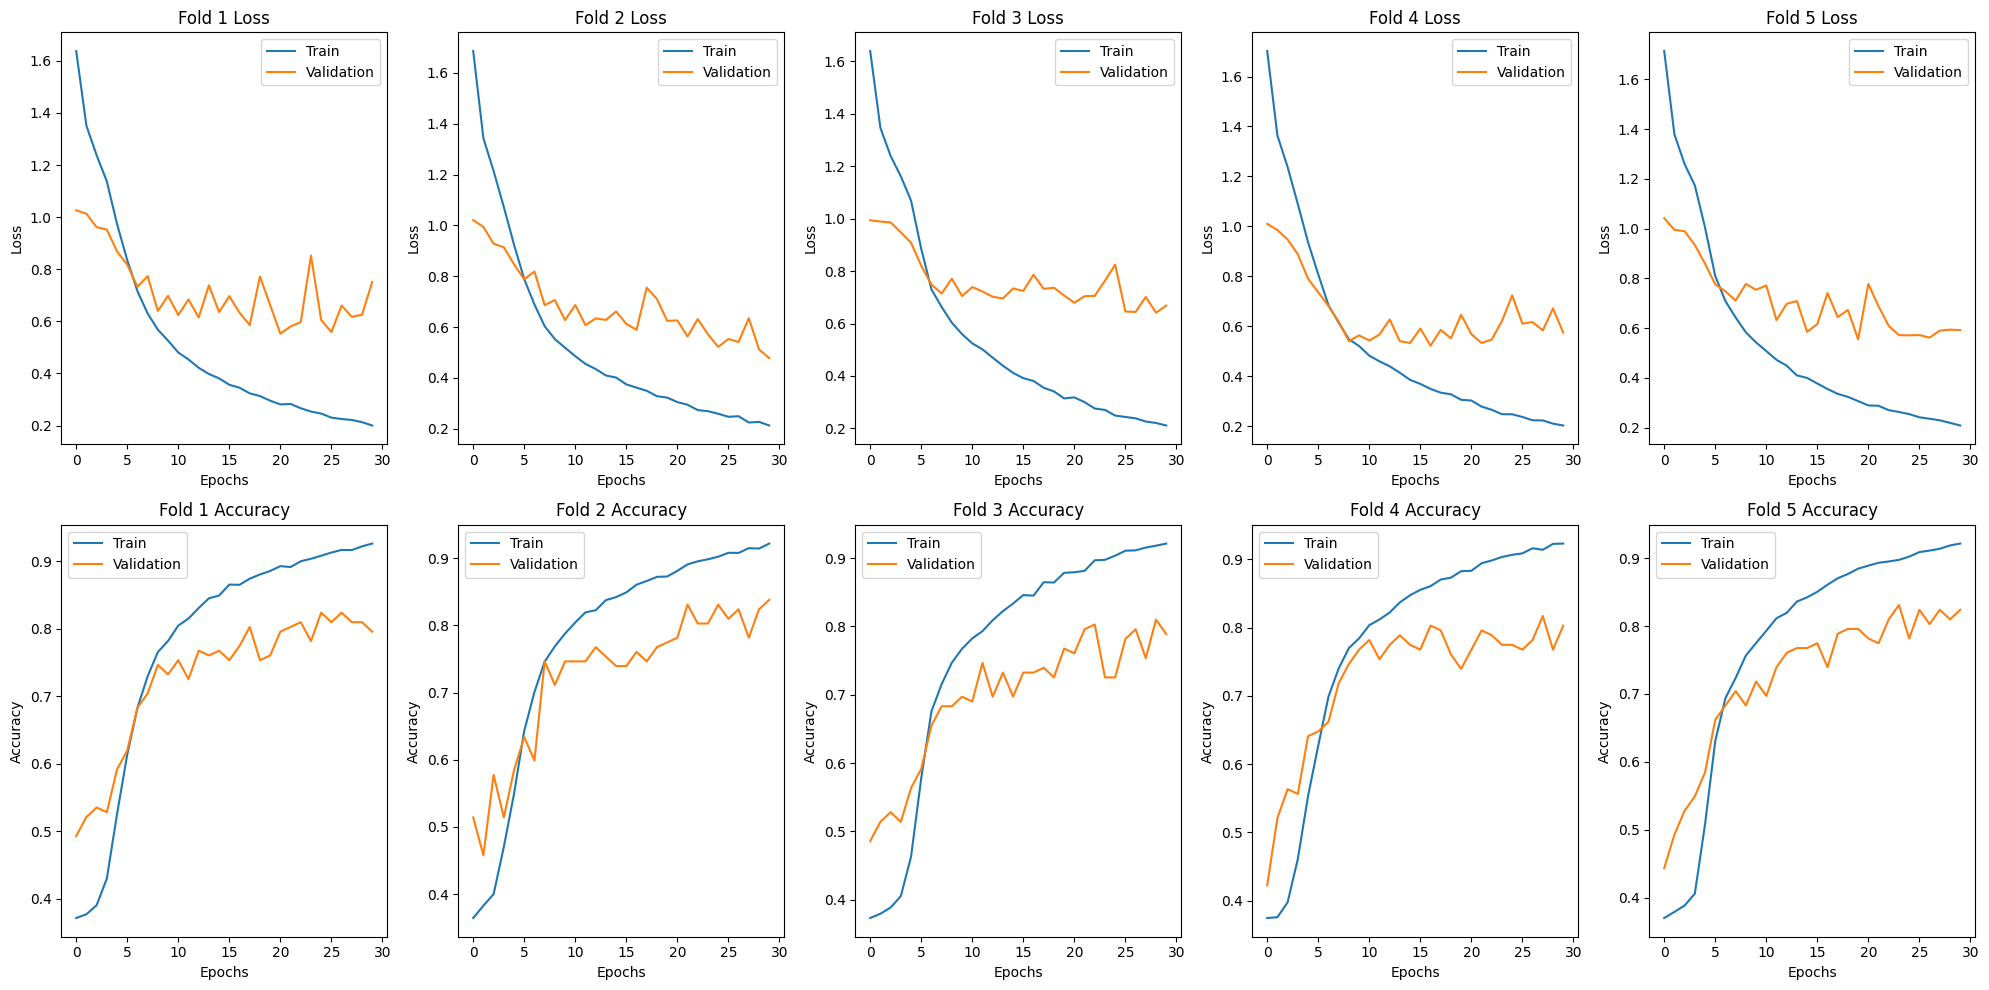

Training and evaluating the model...


NameError: name 'model' is not defined

In [26]:

if CV_DL:
    if DO_TRANSFORMER_VISION:
        # Train and evaluate deep learning models
        print("Building Transformer model...")
        patch_size = 30
        embed_dim = 64
        num_heads = 4
        mlp_dim = 128  # patch_size * patch_size * input_shape[1]
        num_layers = 4
        dropout_rate = 0.3

        # Create the model
        perform_vit_cross_validation(X_original, y_original, X_augmented, y_augmented, patch_size, embed_dim, num_heads, mlp_dim, num_layers, dropout_rate,
                                    n_splits=DL_CV_FOLD, epochs=DL_EPOCH, batch_size=DL_BATCH_SIZE, 
                                    vit_version = DL_TRANSFORMER_VISION_VERSION, val_set = 0.2,
                                    do_opt = True, models_folder = "/kaggle/working/CV_VIT_models", results_folder = "/kaggle/working/CV_VIT_results")

    # Train the model
    print("Training and evaluating the model...")
    # Start the timer
    start_time = time.time()
    model_history = model.fit(X_train, y_train, batch_size=DL_BATCH_SIZE,
                              epochs=DL_EPOCH, validation_data=(X_val, y_val), shuffle=True, callbacks=callbacks)
    # End the timer
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    # Print the elapsed time
    print("Training time: {:.2f} seconds".format(elapsed_time))
    # Compile the model

    # Save the deep learning model
    print("Saving model to ", dl_model_path)
    model.save(dl_model_path)

    # Save the deep learning model's weights
    print("Saving model weights to ", dl_weights_path)
    model.save_weights(dl_weights_path)

    # Evaluating the model
    print("Evaluating the CNN model... ")
    # Calculate model loss and accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test loss:", test_loss)
    print("Test accuracy:", test_accuracy)

    # Save the model's metrics
    print("Saving the model metrics to ", dl_metrics_path)
    save_dl_metrics(model_history, test_loss,
                    test_accuracy, dl_metrics_path)

    # Plot the model history
    plot_dl_history(model_history)